<a href="https://colab.research.google.com/github/venkidev21/23it060-AIML-Assignment-/blob/main/aiok_clean_Version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# aiok_clean_Version3.ipynb

**Advanced Food Category Classifier (Colab-ready)**

Features included:
- Data loading and cleaning
- Feature engineering
- SMOTE balancing
- XGBoost training and evaluation
- Feature importance (XGBoost)
- Top-N confidence bar chart
- Nutrition health tips
- Interactive prediction (input-based) for Colab



In [ ]:
# Uncomment to install required packages in a fresh Colab runtime
# !pip install xgboost imbalanced-learn joblib shap

# If you want to visualize shap plots in Colab you may also need:
# !pip install shap


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported')

Libraries imported


In [ ]:
# --- LOAD DATA ---
# Upload your 'food.csv' to Colab and set the correct path if needed
DATA_PATH = '/content/food.csv'   # change if you uploaded elsewhere

try:
    df = pd.read_csv(DATA_PATH)
    print('Loaded', len(df), 'rows from', DATA_PATH)
    display(df.head())
except Exception as e:
    print('Failed to load', DATA_PATH)
    print('Error:', e)
    print('\nIf you are using Colab, use the left-side Files panel to upload food.csv or change DATA_PATH.')

Loaded 1174 rows from /content/food.csv


,Food Name,Category Name,Calcium,Calories,Carbs,Cholesterol,Copper,Fats,Fiber,Folate,...,Vitamin D,Vitamin E,Vitamin K,Omega-3 - ALA,Omega-6 - Eicosadienoic acid,Omega-6 - Gamma-linoleic acid,Omega-3 - Eicosatrienoic acid,Omega-6 - Dihomo-gamma-linoleic acid,Omega-6 - Linoleic acid,Omega-6 - Arachidonic acid
0,Acerola,Fruits,0.012,32,7.7,0.0,0.00009,0.30,1.1,0.000014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Apple,Fruits,0.006,52,14.0,0.0,0.00003,0.17,2.4,0.000003,...,0.0,0.00018,0.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apricot,Fruits,0.013,48,11.0,0.0,0.00008,0.39,2.0,0.000009,...,0.0,0.00089,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dried fruit,Fruits,0.055,241,63.0,0.0,0.00034,0.51,7.3,0.000010,...,0.0,0.00430,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Avocado,Fruits,0.012,160,8.5,0.0,0.00019,15.00,6.7,0.000081,...,0.0,0.00210,0.000021,0.11,0.0,0.02,NaN,NaN,NaN,NaN


In [ ]:
# --- SELECT FEATURES & TARGET ---
features = ['Calories', 'Protein', 'Fats', 'Carbs', 'Fiber', 'Sugar', 'Sodium',
            'Vitamin C', 'Calcium', 'Cholesterol', 'Saturated Fat']
target = 'Category Name'

# Keep rows that have all required features and the target
data = df[features + [target]].dropna()
print('Rows after dropping NA for selected fields:', len(data))

X = data[features].astype(float)
y = data[target].astype(str)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('Number of classes:', len(le.classes_))
print('Classes:', list(le.classes_))

Rows after dropping NA for selected fields: 824
Number of classes: 18
Classes: ['Baby Foods', 'Baked Products', 'Beverages', 'Dairy', 'Fast Foods', 'Fruits', 'Grains', 'Greens', 'Meals, Entrees, and Side Dishes', 'Meat', 'Mushrooms', 'Nuts', 'Oils and Sauces', 'Seafood', 'Soups', 'Spices', 'Sweets', 'Vegetables']


In [ ]:
# --- OPTIONAL: remove extreme outliers per-feature (1st and 99th percentiles) ---
remove_outliers = True
if remove_outliers:
    X_work = X.copy()
    y_work = pd.Series(y_encoded)
    for col in features:
        low, high = X_work[col].quantile(0.01), X_work[col].quantile(0.99)
        mask = (X_work[col] >= low) & (X_work[col] <= high)
        X_work = X_work[mask]
        y_work = y_work[mask.values]
    X = X_work
    y_encoded = y_work.values
    print('Rows after outlier filtering:', len(X))
else:
    print('Outlier removal skipped')

Rows after outlier filtering: 744


In [ ]:
# --- FEATURE ENGINEERING ---
X = X.copy()
X['Protein_to_Fat'] = X['Protein'] / (X['Fats'] + 1e-6)
X['Sugar_to_Carbs'] = X['Sugar'] / (X['Carbs'] + 1e-6)
X['Energy_Density'] = X['Calories'] / (X['Protein'] + X['Fats'] + X['Carbs'] + 1e-6)
X['Fiber_to_Carbs'] = X['Fiber'] / (X['Carbs'] + 1e-6)

print('Feature shape after engineering:', X.shape)
display(X.head())

Feature shape after engineering: (744, 15)


,Calories,Protein,Fats,Carbs,Fiber,Sugar,Sodium,Vitamin C,Calcium,Cholesterol,Saturated Fat,Protein_to_Fat,Sugar_to_Carbs,Energy_Density,Fiber_to_Carbs
1,52.0,0.26,0.17,14.0,2.4,10.00,0.001,0.0046,0.006,0.0,0.03,1.529403,0.714286,3.603603,0.171429
2,48.0,1.40,0.39,11.0,2.0,9.20,0.001,0.0100,0.013,0.0,0.03,3.589734,0.836364,3.752932,0.181818
3,241.0,3.40,0.51,63.0,7.3,53.00,0.010,0.0010,0.055,0.0,0.02,6.666654,0.841270,3.601853,0.115873
4,160.0,2.00,15.00,8.5,6.7,0.66,0.007,0.0100,0.012,0.0,2.10,0.133333,0.077647,6.274510,0.788235
5,89.0,1.10,0.33,23.0,2.6,12.00,0.001,0.0087,0.005,0.0,0.11,3.333323,0.521739,3.643062,0.113043


In [ ]:
# --- STANDARDIZE FEATURES ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled shape:', X_scaled.shape)

Scaled shape: (744, 15)


In [ ]:
# --- HANDLE IMBALANCE WITH SMOTE ---
unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
min_class_size = class_counts.min()
print('Class counts (min):', min_class_size)

if min_class_size > 1:
    k_neighbors = min(5, min_class_size - 1)
    sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(X_scaled, y_encoded)
    print('Rows before SMOTE:', X_scaled.shape[0], 'after SMOTE:', X_res.shape[0])
else:
    print('SMOTE not applied: some classes have only 1 sample. Using original data.')
    X_res, y_res = X_scaled, y_encoded

# Quick distribution check
import collections
print('Class distribution after resampling:', collections.Counter(y_res))

Class counts (min): 3
Rows before SMOTE: 744 after SMOTE: 1260
Class distribution after resampling: Counter({np.int64(5): 70, np.int64(17): 70, np.int64(13): 70, np.int64(3): 70, np.int64(10): 70, np.int64(6): 70, np.int64(9): 70, np.int64(15): 70, np.int64(11): 70, np.int64(7): 70, np.int64(16): 70, np.int64(12): 70, np.int64(2): 70, np.int64(14): 70, np.int64(1): 70, np.int64(4): 70, np.int64(8): 70, np.int64(0): 70})


In [ ]:
# --- TRAIN / TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)
print('Train size:', len(X_train), 'Test size:', len(X_test))

Train size: 1008 Test size: 252


Model accuracy: 87.30%

Classification report:
                                  precision    recall  f1-score   support

                     Baby Foods       1.00      1.00      1.00        14
                 Baked Products       0.80      0.86      0.83        14
                      Beverages       0.86      0.86      0.86        14
                          Dairy       0.82      1.00      0.90        14
                     Fast Foods       0.80      0.86      0.83        14
                         Fruits       0.92      0.86      0.89        14
                         Grains       0.79      0.79      0.79        14
                         Greens       0.87      0.93      0.90        14
Meals, Entrees, and Side Dishes       0.80      0.86      0.83        14
                           Meat       0.93      1.00      0.97        14
                      Mushrooms       1.00      1.00      1.00        14
                           Nuts       0.92      0.79      0.85        14
  

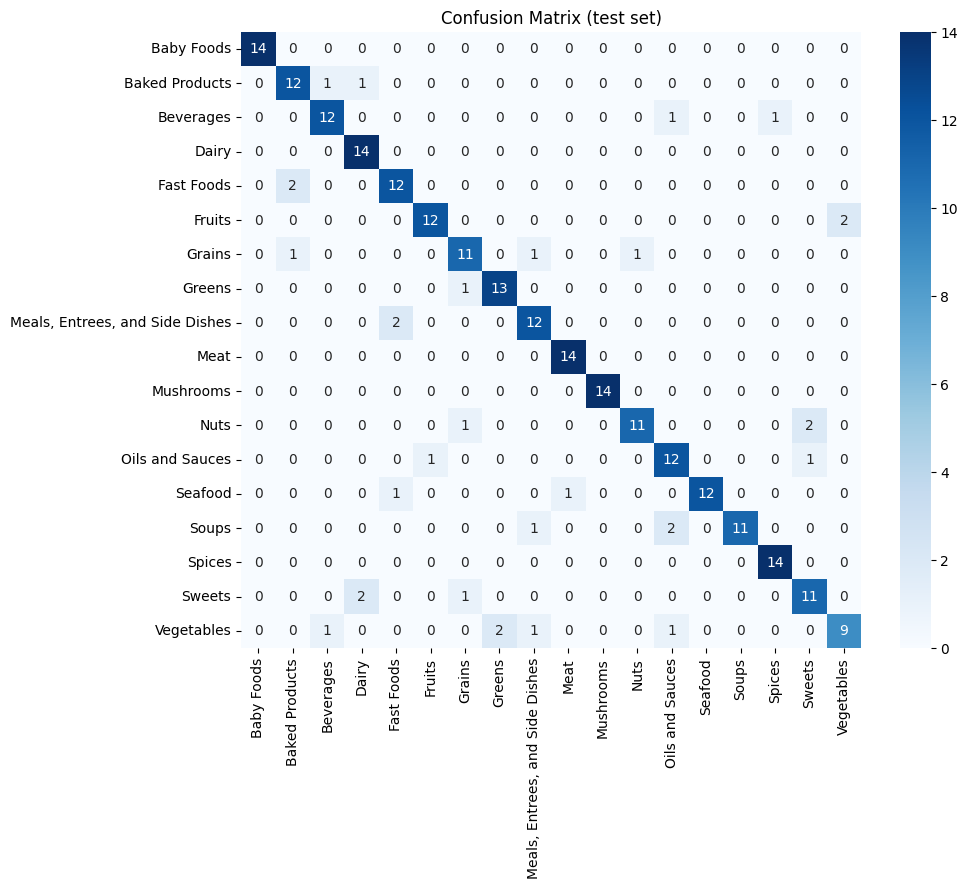

In [ ]:
# --- TRAIN XGBOOST MODEL ---
model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {acc*100:.2f}%")
print('\nClassification report:\n', classification_report(y_test, y_pred, target_names=le.inverse_transform(np.unique(y_test))))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform(np.unique(y_test)), yticklabels=le.inverse_transform(np.unique(y_test)))
plt.title('Confusion Matrix (test set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# --- SAVE MODEL, SCALER, ENCODER ---
joblib.dump(model, 'food_category_xgb_v3.pkl')
joblib.dump(le, 'label_encoder_v3.pkl')
joblib.dump(scaler, 'scaler_v3.pkl')
print('Saved: food_category_xgb_v3.pkl, label_encoder_v3.pkl, scaler_v3.pkl')

Saved: food_category_xgb_v3.pkl, label_encoder_v3.pkl, scaler_v3.pkl


<Figure size 800x600 with 0 Axes>

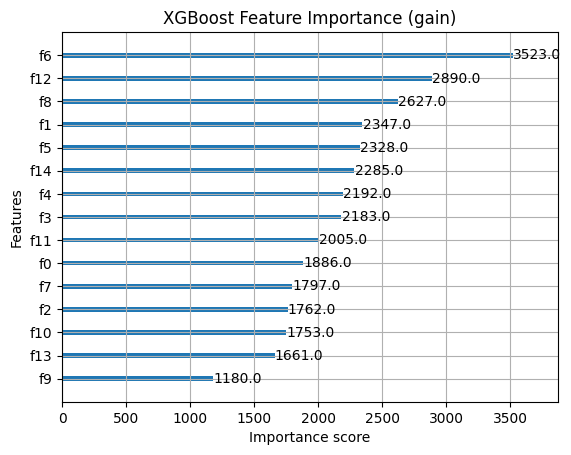

In [ ]:
# --- FEATURE IMPORTANCE (XGBoost) ---
from xgboost import plot_importance
plt.figure(figsize=(8,6))
plot_importance(model, max_num_features=15)
plt.title('XGBoost Feature Importance (gain)')
plt.show()

# Optional: SHAP explanation (commented because shap can be heavy in Colab)
# import shap
# explainer = shap.TreeExplainer(model)
# shap_vals = explainer.shap_values(X_train)
# shap.summary_plot(shap_vals, X_train, feature_names=X.columns)


In [ ]:
# --- HELPER FUNCTIONS ---

def predict_top_categories_from_values(cal, prot, fats, carbs, fiber, sugar, sodium, vit_c, calcium, chol, sat_fat, top_n=5):
    sample = pd.DataFrame([{
        'Calories': cal,
        'Protein': prot,
        'Fats': fats,
        'Carbs': carbs,
        'Fiber': fiber,
        'Sugar': sugar,
        'Sodium': sodium,
        'Vitamin C': vit_c,
        'Calcium': calcium,
        'Cholesterol': chol,
        'Saturated Fat': sat_fat
    }])
    sample['Protein_to_Fat'] = sample['Protein'] / (sample['Fats'] + 1e-6)
    sample['Sugar_to_Carbs'] = sample['Sugar'] / (sample['Carbs'] + 1e-6)
    sample['Energy_Density'] = sample['Calories'] / (sample['Protein'] + sample['Fats'] + sample['Carbs'] + 1e-6)
    sample['Fiber_to_Carbs'] = sample['Fiber'] / (sample['Carbs'] + 1e-6)
    sample_scaled = scaler.transform(sample)
    probs = model.predict_proba(sample_scaled)[0]
    top_idx = probs.argsort()[-top_n:][::-1]
    return [(le.inverse_transform([i])[0], float(probs[i])) for i in top_idx]


def get_foods_by_category(category, count=5, csv_path=DATA_PATH):
    df_local = pd.read_csv(csv_path)
    foods = df_local[df_local['Category Name'] == category]['Food Name'].dropna().unique()
    return list(foods)[:count]


def show_top_predictions_chart(predictions):
    cats = [c for c, _ in predictions]
    probs = [p for _, p in predictions]
    plt.figure(figsize=(8,4))
    plt.barh(cats[::-1], probs[::-1])
    plt.xlabel('Confidence')
    plt.xlim(0,1)
    plt.title('Top Predicted Categories')
    plt.show()


def suggest_health_tip(category):
    tips = {
        'Fast Foods': '⚠️ Limit intake — try low saturated fat and fewer fried items.',
        'Beverages': '🥤 Watch added sugars; prefer water or unsweetened drinks.',
        'Fruits': '🍎 Excellent choice — high in vitamins and fiber.',
        'Dairy': '🥛 Good protein and calcium; watch cholesterol if applicable.',
        'Soups': '🍲 Good for satiety — watch sodium content.',
        'Sweets': '🍬 Eat occasionally; high in sugars.',
    }
    return tips.get(category, '👍 Balanced food choice — enjoy in moderation!')

print('Helper functions ready')

Helper functions ready


Interactive prediction — enter nutrition values (press Enter after each)
Calories: 100
Protein: 10
Fats: 20
Carbs: 20
Fiber: 30
Sugar: 20
Sodium: 20
Vitamin C: 20
Calcium: 20
Cholesterol: 60
Saturated Fat: 30

Top predicted categories:
- Spices: 44.32%
  Example foods: Allspice, Star anise, Bay leaf, Caraway spice, Cardamom
- Dairy: 19.17%
  Example foods: Blue cheese, Brie, Camembert, Cheese, Cottage cheese
- Fast Foods: 7.38%
  Example foods: Hot dog, Potato wedges, Veggie burger, Hash browns, Burrito
- Oils and Sauces: 6.05%
  Example foods: Lard, Russian dressing, Thousand island, French dressing, Italian dressing
- Nuts: 5.16%
  Example foods: Alfalfa seeds, Radish seeds, Lotus seeds, Safflower, Acorns


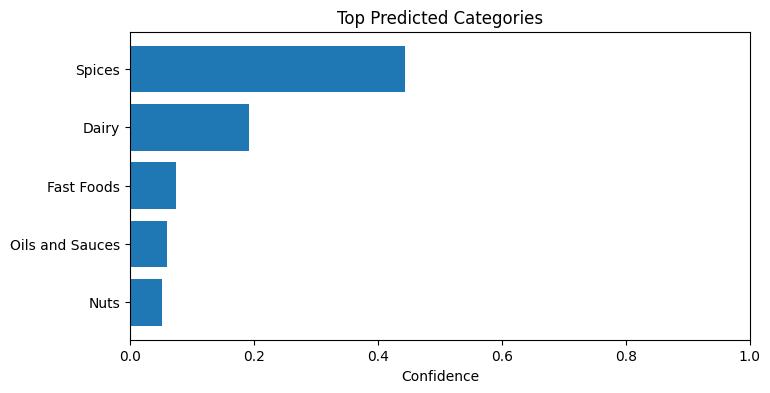


Health tip for top prediction:
👍 Balanced food choice — enjoy in moderation!


In [ ]:
# --- INTERACTIVE PREDICTION (Colab input) ---
print('Interactive prediction — enter nutrition values (press Enter after each)')
try:
    cal = float(input('Calories: '))
    prot = float(input('Protein: '))
    fats = float(input('Fats: '))
    carbs = float(input('Carbs: '))
    fiber = float(input('Fiber: '))
    sugar = float(input('Sugar: '))
    sodium = float(input('Sodium: '))
    vit_c = float(input('Vitamin C: '))
    calcium = float(input('Calcium: '))
    chol = float(input('Cholesterol: '))
    sat_fat = float(input('Saturated Fat: '))

    top = predict_top_categories_from_values(cal, prot, fats, carbs, fiber, sugar, sodium, vit_c, calcium, chol, sat_fat, top_n=5)
    print('\nTop predicted categories:')
    for cat, p in top:
        print(f"- {cat}: {p*100:.2f}%")
        print('  Example foods:', ', '.join(get_foods_by_category(cat)))
    show_top_predictions_chart(top)
    print('\nHealth tip for top prediction:')
    print(suggest_health_tip(top[0][0]))
except Exception as e:
    print('Interactive input skipped or failed (if running automated). Error:', e)
    print('You can still call predict_top_categories_from_values() manually.')


Top predicted categories:
- Fast Foods: 40.52%
  Example foods: Hot dog, Potato wedges, Veggie burger, Hash browns, Burrito
- Meals, Entrees, and Side Dishes: 35.10%
  Example foods: Beef Stroganoff, Bran cereal, Kellogg's Apple Jacks, Cap'n Crunch Cereal, General Mills Cheerios
- Soups: 7.62%
  Example foods: Asparagus soup, Black bean soup, Soup beans, Celery soup, Broccoli cheese soup
- Baby Foods: 6.89%
  Example foods: Baby food, Zwieback, Cherry juice


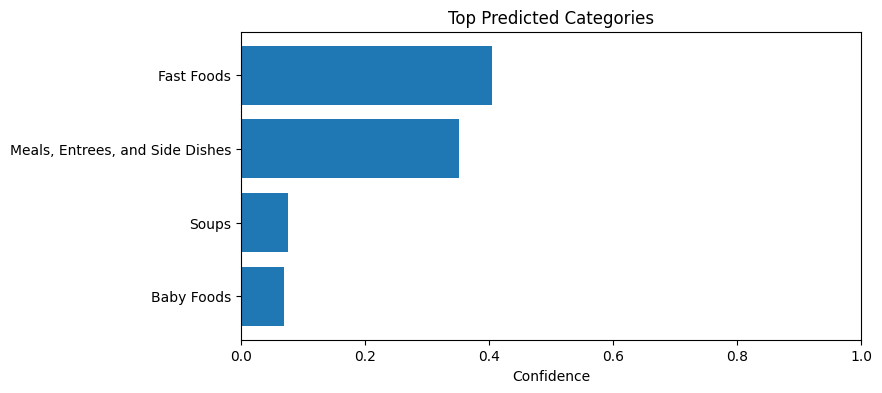


Tip: ⚠️ Limit intake — try low saturated fat and fewer fried items.


In [ ]:
# --- EXAMPLE USAGE (programmatic) ---
sample_vals = {
    'cal': 300.0,
    'prot': 25.0,
    'fats': 15.0,
    'carbs': 30.0,
    'fiber': 5.0,
    'sugar': 10.0,
    'sodium': 200.0,
    'vit_c': 10.0,
    'calcium': 20.0,
    'chol': 10.0,
    'sat_fat': 5.0
}
top = predict_top_categories_from_values(sample_vals['cal'], sample_vals['prot'], sample_vals['fats'],
                                         sample_vals['carbs'], sample_vals['fiber'], sample_vals['sugar'],
                                         sample_vals['sodium'], sample_vals['vit_c'], sample_vals['calcium'],
                                         sample_vals['chol'], sample_vals['sat_fat'], top_n=4)

print('\nTop predicted categories:')
for cat, p in top:
    print(f"- {cat}: {p*100:.2f}%")
    print('  Example foods:', ', '.join(get_foods_by_category(cat)))
show_top_predictions_chart(top)
print('\nTip:', suggest_health_tip(top[0][0]))